# 1. pipeline
- https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers_doc/en/pytorch/write_own_pipeline.ipynb

## package

In [26]:
from diffusers import DDPMPipeline
from diffusers import DDPMScheduler, UNet2DModel, AutoencoderKL, UNet2DConditionModel
from diffusers import PNDMScheduler, UniPCMultistepScheduler
from transformers import CLIPTextModel, CLIPTokenizer

from PIL import Image
from tqdm.auto import tqdm

import torch
import numpy as np


## Deconstruct naseline pipeline : DDPM

100%|██████████| 30/30 [00:00<00:00, 30.01it/s]


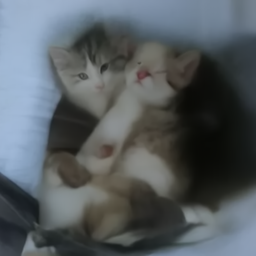

In [27]:
ddpm = DDPMPipeline.from_pretrained("google/ddpm-cat-256").to("cuda")
image = ddpm(num_inference_steps=30).images[0]
image

In [28]:
ddpm_schedular = DDPMScheduler.from_pretrained("google/ddpm-cat-256")
unet = UNet2DModel.from_pretrained("google/ddpm-cat-256").to("cuda")

In [29]:
ddpm_schedular.set_timesteps(50)

In [30]:
ddpm_schedular.timesteps

tensor([980, 960, 940, 920, 900, 880, 860, 840, 820, 800, 780, 760, 740, 720,
        700, 680, 660, 640, 620, 600, 580, 560, 540, 520, 500, 480, 460, 440,
        420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180, 160,
        140, 120, 100,  80,  60,  40,  20,   0])

In [31]:
# Create random noise
sample_size = unet.config.sample_size
noise = torch.randn((1,3,sample_size,sample_size)).to("cuda")

In [32]:
# forward pass

input = noise

for t in ddpm_schedular.timesteps:
    with torch.no_grad():
        noisy_residual = unet(input, t).sample
    # step() : predicts img at the previous step
    previous_noisy_sample = ddpm_schedular.step(noisy_residual, t, input).prev_sample 
    input = previous_noisy_sample

In [33]:
# convert output into an image

image = (input/2+0.5).clamp(0,1)
image = image.cpu().permute(0,2,3,1).numpy()[0]
image = Image.fromarray((image*255).round().astype("uint8"))

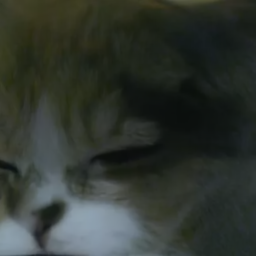

In [34]:
image

## Deconstruct the Stable Diffusion pipeline
- Consist of VAE, UNet, text encoders

In [35]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder")
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

In [36]:
# scheduler
schedular = UniPCMultistepScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

In [37]:
# seed up inference (cuda) - they hace trainable weights
torch_device = "cuda"

vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device)

UNet2DConditionModel(
  (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=320, out_features=1280, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (down_blocks): ModuleList(
    (0): CrossAttnDownBlock2D(
      (attentions): ModuleList(
        (0-1): 2 x Transformer2DModel(
          (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
          (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
          (transformer_blocks): ModuleList(
            (0): BasicTransformerBlock(
              (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
              (attn1): Attention(
                (to_q): Linear(in_features=320, out_features=320, bias=False)
                (to_k): Linear(in_features=320, out_features=320, bias=False)
                (to_v): Linear(in_features=320, out_fe

### Create text embedding
- getting tokenize the text to generate embeddings.
- Using condition the UNet

In [38]:
prompt = ["a photograph of an astronaut riding a hourse"]
height = 512
width = 512
num_inference_steps = 25
guidance_scale = 7.5
generator = torch.manual_seed(0)
batch_size = len(prompt)

In [39]:
# Tokenize the text & generate the embeddings from the prompt
text_input = tokenizer(
    prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
)

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

In [40]:
# generate the unconditional text embeddings for padding token.
# These need to have the same shape as the conditional text embeddings (batch_size and seq_length)
max_length = text_input.input_ids.shape[-1] # 77
uncond_input = tokenizer([""]*batch_size, padding="max_length", max_length=max_length, return_tensors="pt")
uncond_emneddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

In [41]:
text_embeddings = torch.cat([uncond_emneddings, text_embeddings])

### Create random noise

In [42]:
# vae model has 3-downsampling layers -> W, H are divided by 8
2 ** (len(vae.config.block_out_channels)-1) == 8

True

In [43]:
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator = generator,
)
latents = latents.to(torch_device)

/tmp/ipykernel_459570/2600091174.py:2: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


### Denoise the image

In [44]:
latents = latents * schedular.init_noise_sigma

In [45]:
schedular.set_timesteps(num_inference_steps=num_inference_steps)

for t in tqdm(schedular.timesteps):
    # if we do classifier-free guidance to expand the latents, doing avoide forward passes.
    latnet_model_input = torch.cat([latents]*2)
    
    latnet_model_input = schedular.scale_model_input(latnet_model_input, timestep=t)
    
    # predict the noise residual 
    with torch.no_grad():
        noise_pred = unet(latnet_model_input, t, encoder_hidden_states=text_embeddings).sample
        
    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale*(noise_pred_text - noise_pred_uncond)
    
    # compute the previous noisy sample x_t -> x_t-1
    latents = schedular.step(noise_pred, t, latents).prev_sample

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:03<00:00,  7.90it/s]


### Decode the image

In [46]:
# image latents decode with vae
latents = 1/0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

In [47]:
# generate image!
image = (image / 2 + 0.5).clamp(0,1)
image = image.detach().cpu().permute(0,2,3,1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images

[<PIL.Image.Image image mode=RGB size=512x512>]

In [25]:
len(pil_images)

1

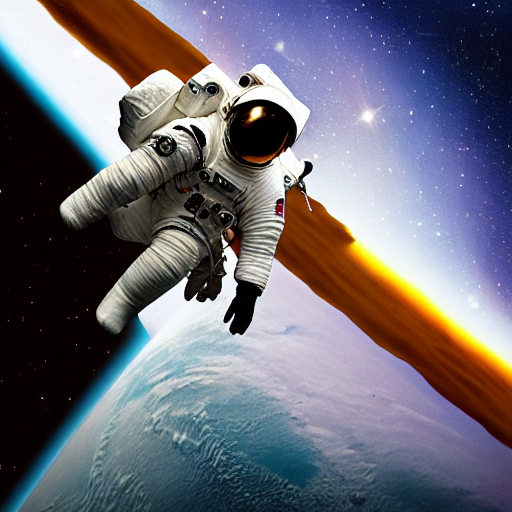

In [48]:
pil_images[0]